In [4]:
#Import libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import data_module_covid as dmc

Read the data from  Helsingin Sanomat (https://github.com/HS-Datadesk/koronavirus-avoindata)

In [7]:

# data = requests.get("https://w3qa5ydb4l.execute-api.eu-west-1.amazonaws.com/prod/finnishCoronaData")
# data_json = data.json()
data_json = dmc.get_data_from_HS()
#Take only the data for confirmed cases:
df = pd.DataFrame.from_dict(data_json["confirmed"])

print(df.head())
print(df.dtypes)



id                      date healthCareDistrict infectionSourceCountry  \
0  1  2020-01-29T11:00:00.000Z              Lappi                    CHN   
1  2  2020-02-26T11:00:00.000Z                HUS                    ITA   
2  3  2020-03-01T11:00:00.000Z                HUS                    FIN   
3  4  2020-02-28T11:00:00.000Z                HUS                    ITA   
4  5  2020-03-01T11:00:00.000Z                HUS                    FIN   

  infectionSource  
0         unknown  
1         unknown  
2               2  
3         unknown  
4               4  
id                        object
date                      object
healthCareDistrict        object
infectionSourceCountry    object
infectionSource           object
dtype: object


Now, make a function that extracts the confirmed cases of COVID-19 with their timestamps.

Then we group them to get the daily confirmed cases.

There are 223 (at the time) confirmed cases with all having their own timestamps.
Get the cumulative sum of the confirmed cases and visualise the daily counts and cumulative sum.

count  cum_sum
date                      
2020-01-29      1        1
2020-02-26      1        2
2020-02-28      1        3
2020-03-01      3        6
2020-03-02      1        7
2020-03-05      5       12
2020-03-06      3       15
2020-03-07      4       19
2020-03-08      5       24
2020-03-09      9       33
2020-03-10      7       40
2020-03-11     25       65
2020-03-12     46      111
2020-03-13     44      155
2020-03-14     70      225


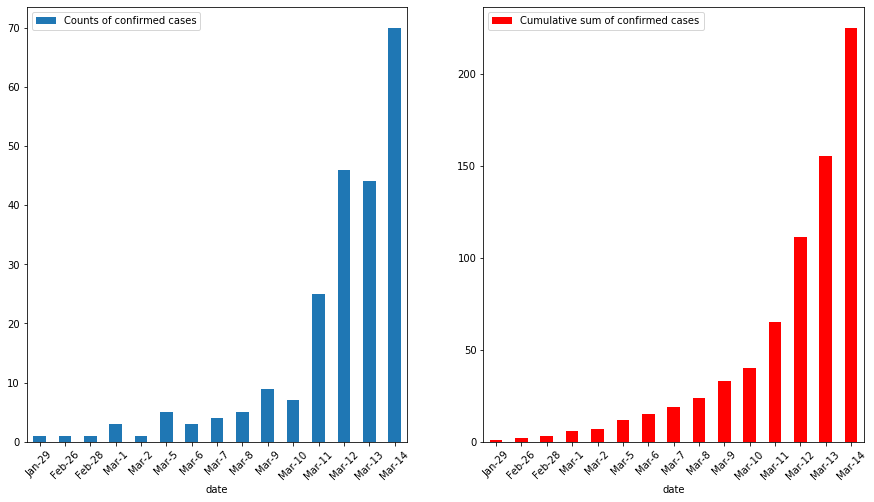

In [6]:
covid = dmc.extract_counts(df)

covid['cum_sum'] = covid['count'].cumsum()
print(covid)

date_mapping = ["{}-{}".format(x.strftime("%b"),x.day) for x in covid.index]
fig,axes = plt.subplots(1,2,figsize=(15,8))


covid.plot.bar(y='count',ax=axes[0],label="Counts of confirmed cases")
axes[0].set_xticklabels(date_mapping,rotation=45);

covid.plot.bar(y = 'cum_sum',ax=axes[1],color = 'red',label="Cumulative sum of confirmed cases")
axes[1].set_xticklabels(date_mapping,rotation=45);



